In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection # Scikit-learn (sklearn)

import torch
from torch import nn # PyTorch's building blocks for neural networks
from torchmetrics import MeanAbsolutePercentageError # Mean absolute percentage error

torch.__version__

'2.4.0'

<br>

## 1. Data loading & preprocessing

In [51]:
from sklearn.datasets import fetch_california_housing

# 캘리포니아 주택 데이터셋 로드
housing = fetch_california_housing()

# Pandas DataFrame으로 변환
df = pd.DataFrame(housing.data, columns=housing.feature_names)

# 타겟(목표값) 추가
df['Target'] = housing.target

# 데이터셋의 첫 5행 출력
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [53]:
# 목표 변수 (target) 가져오기
target = housing.target

# 목표 변수의 처음 10개 값 출력
print(target[:10])

[4.526 3.585 3.521 3.413 3.422 2.697 2.992 2.414 2.267 2.611]


In [55]:
# 2. 특성과 목표 변수 추출
x_data = housing.data
y_data = housing.target

# 3. 목표 변수 y_data를 2차원 배열로 변환
y_data = np.reshape(y_data, (-1, 1))

print("x_data shape:", x_data.shape)
print("y_data shape:", y_data.shape)

x_data shape: (20640, 8)
y_data shape: (20640, 1)


<br>

## 2. Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [58]:
X = torch.tensor(np.array(x_data)).type(torch.float)
y = torch.tensor(np.array(y_data)).type(torch.float)

In [60]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(X, y,
                                                                                  test_size=0.3,
                                                                                  random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

torch.Size([14448, 8])
torch.Size([6192, 8])
torch.Size([14448, 1])
torch.Size([6192, 1])


<br>

## 3. Build & Train the model 

<br>
<br>

### 1) Build the model

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [66]:
class MLP_Regressor(nn.Module): # should inherit the class nn.Module
    
    
    def __init__(self, num_features, num_output, num_nodes=64):
        
        super().__init__()
        
        self.sequential_stack = nn.Sequential( # Sequential-stack
            nn.Linear(in_features=num_features, out_features=num_nodes),
            # nn.BatchNorm1d(num_nodes),
            nn.ELU(),
            nn.Linear(in_features=num_nodes, out_features=num_nodes),
            nn.ELU(), 
            nn.Linear(in_features=num_nodes, out_features=num_nodes),
            nn.ELU(), 
            nn.Dropout(0.4),
            nn.Linear(in_features=num_nodes, out_features=num_output)
        )
    
    def forward(self, x): # forward-pass
        
        return self.sequential_stack(x)

<br>
<br>

### 2) Check the model

In [69]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = MLP_Regressor(num_features=8, 
                      num_output=1, 
                      num_nodes=64).to(device)

In [71]:
model.eval()

with torch.inference_mode(): 
    
    untrained_preds = model(test_data.to(device)) # 모델 & 데이터는 동일한 디바이스 위에 위치해있어야 함
    
print(untrained_preds[:10])

tensor([[ 4.8314],
        [ 3.9772],
        [ 4.8339],
        [ 0.5026],
        [ 1.4229],
        [-0.2557],
        [ 3.1767],
        [ 1.9933],
        [10.8079],
        [ 0.4689]])


<br>
<br>

### 3) Train the model

In [74]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = MLP_Regressor(num_features=8, 
                      num_output=1, 
                      num_nodes=64).to(device)

In [76]:
loss_fn = nn.MSELoss() # Mean squared error

optimizer = torch.optim.Adam(params=model.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.001) # "l"earning "r"ate 

metric_MAPE = MeanAbsolutePercentageError().to(device) # from torchmetrics import MeanAbsolutePercentageError

In [78]:
torch.manual_seed(42)


train_data, train_label = train_data.to(device), train_label.to(device)
test_data, test_label   = test_data.to(device), test_label.to(device)
 
    
loss_train_list = []
loss_test_list = []
mape_train_list = []
mape_test_list = []

for epoch in range(1000):
    
    # 모델을 training mode로 설정 (default state)
    model.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    y_predicted = model(train_data)
    
    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(y_predicted, train_label) # <- nn.MSELoss()
    loss_train_list.append(loss_train.item())
    
    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        y_predicted_test = model(test_data)
        
        # Test cost 계산
        loss_test = loss_fn(y_predicted_test, test_label)
        loss_test_list.append(loss_test.item())
        

    mape_train = metric_MAPE(y_predicted, train_label) 
    mape_train_list.append(mape_train.item())
    
    mape_test  = metric_MAPE(y_predicted_test, test_label)
    mape_test_list.append(mape_test.item())
    
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, MAPE: {mape_train:.2f}% | Test loss: {loss_test:.5f}, Test MAPE: {mape_test:.2f}%")

Epoch: 0 | Loss: 538.60474, MAPE: 9.61% | Test loss: 99.46904, Test MAPE: 5.43%
Epoch: 100 | Loss: 1.61586, MAPE: 0.65% | Test loss: 1.34697, Test MAPE: 0.61%
Epoch: 200 | Loss: 1.54703, MAPE: 0.67% | Test loss: 1.30962, Test MAPE: 0.58%
Epoch: 300 | Loss: 1.41432, MAPE: 0.65% | Test loss: 1.21283, Test MAPE: 0.53%
Epoch: 400 | Loss: 1.19203, MAPE: 0.64% | Test loss: 1.02494, Test MAPE: 0.41%
Epoch: 500 | Loss: 0.88080, MAPE: 0.44% | Test loss: 0.71507, Test MAPE: 0.35%
Epoch: 600 | Loss: 0.88266, MAPE: 0.38% | Test loss: 0.66088, Test MAPE: 0.43%
Epoch: 700 | Loss: 0.76323, MAPE: 0.39% | Test loss: 0.63911, Test MAPE: 0.33%
Epoch: 800 | Loss: 0.81226, MAPE: 0.48% | Test loss: 0.76687, Test MAPE: 0.30%
Epoch: 900 | Loss: 0.76678, MAPE: 0.39% | Test loss: 0.59836, Test MAPE: 0.36%


<br>

## 4. Test the model 

In [80]:
# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    y_predicted = model(test_data.to(device))
    
mape_test = metric_MAPE(y_predicted, test_label.to(device)) 

print('Test MAPE : {:.4f} %'.format(mape_test))

Test MAPE : 0.3084 %


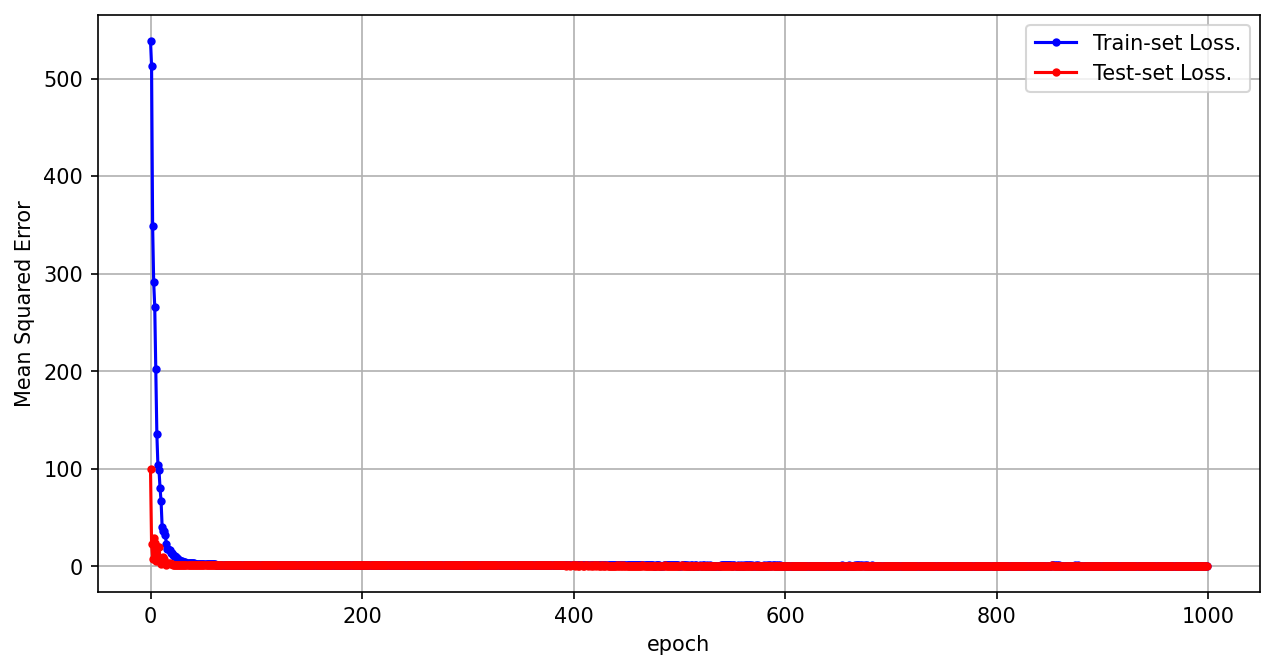

In [82]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs, loss_train_list, marker='.', c='blue', label="Train-set Loss.")
plt.plot(epochs, loss_test_list, marker='.', c='red', label="Test-set Loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.show()

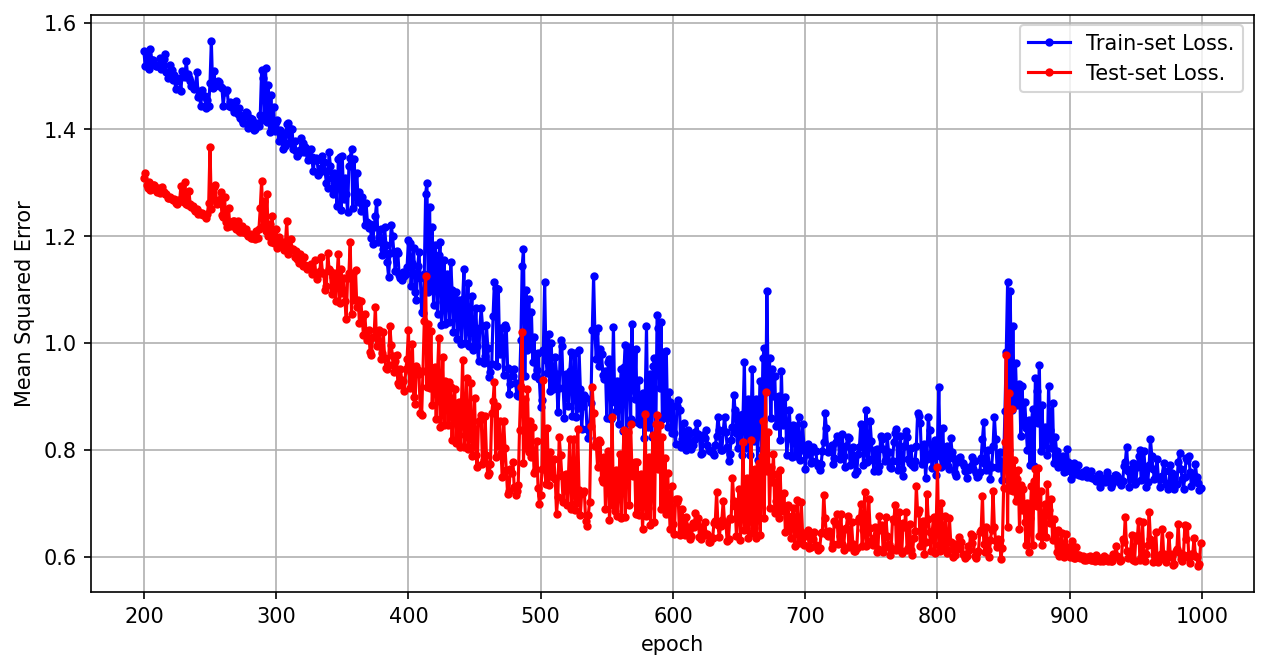

In [86]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs[200:], loss_train_list[200:], marker='.', c='blue', label="Train-set Loss.")
plt.plot(epochs[200:], loss_test_list[200:], marker='.', c='red', label="Test-set Loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.show()

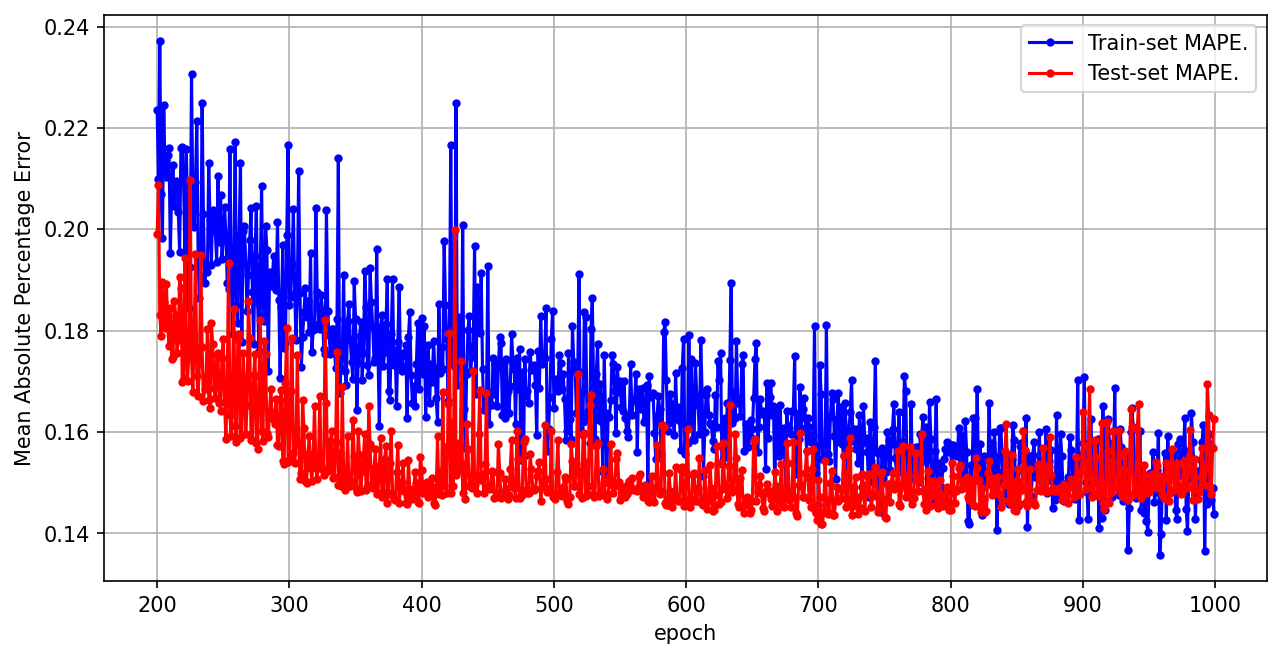

In [59]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs[200:], mape_train_list[200:], marker='.', c='blue', label="Train-set MAPE.")
plt.plot(epochs[200:], mape_test_list[200:], marker='.', c='red', label="Test-set MAPE.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

In [94]:
sample_data = np.array([[0.02731, 0.0, 7.07, 0.0, 0.469, 6.421, 78.9, 4.9671]])
data_tensor = torch.tensor(sample_data).type(torch.float)


# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    prediction = model(data_tensor.to(device))

print(prediction.item()) # get a single scalar number

-4.182353973388672


<br>

## 5. Save the model 

<br>

#### * 모델을 통째로 저장하고 불러오는 것도 가능 @ https://pytorch.org/tutorials/beginner/saving_loading_models.html

#### -> **torch.save(model, PATH)** & **model = torch.load(PATH)**

In [97]:
# Shorter version

torch.save(obj=model.state_dict(), # only parameters
           f='models/usethis_regressor.pth')

In [63]:
# # Longer version (디렉토리부터 생성)


# # 1. 모델 파라미터 파일 저장을 위한 디렉토리 생성 (os.mkdir 함수로 대체하여 사용 가능)

# from pathlib import Path
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)
# # parents=True : any missing parents of this path are created as needed.
# # exist_ok=True : FileExistsError exceptions will be ignored.


# # 2. 모델 파라미터 저장경로 지정 

# MODEL_NAME = "usethis_regressor.pth" # common convention for PyTorch saved models or objects : .pt or .pth
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # WindowsPath('models/usethis_regressor.pth')


# # 3. 모델 파라미터 저장

# print('Saving model to :', MODEL_SAVE_PATH)

# torch.save(obj=model.state_dict(), # only parameters
#            f=MODEL_SAVE_PATH)

In [101]:
loaded_model = MLP_Regressor(num_features=8, 
                             num_output=1, 
                             num_nodes=64) # 모델 구조 생성 

loaded_model.load_state_dict(torch.load(f='models/usethis_regressor.pth')) 
# pickle 파일을 먼저 load 후 paramter 값들을 꺼내어 모델로 load

loaded_model.to(device)

/var/folders/h8/hl46jg551p96ynf4dwy9ln_80000gn/T/ipykernel_24352/3826081060.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f='mo

MLP_Regressor(
  (sequential_stack): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [103]:
# 1. 모델을 evaluation mode로 설정
loaded_model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    y_predicted = model(test_data.to(device))
    
mape_test = metric_MAPE(y_predicted, test_label.to(device)) 

print('Test MAPE : {:.4f} %'.format(mape_test))

Test MAPE : 0.3084 %
